# Esame del corso di "Probabilità e Statistica"

    Claudia Vello (matr. 42016A)
    Appello: 26 gennaio 2024

**CONSEGNA:**

Si consideri il file di dati allegato che contiene le emissioni CO2 divise anche per settori di tutte le città europee. Si richiede di consegnare un notebook con le analisi statistiche di questi dati. Il notebook deve contenere dalle 4 alle 8 figure, essere ben documentato con delle spiegazioni e contenere analisi qualitative e quantitative. Si consiglia di formulare delle ipotesi e poi verificarle con i dati. Siete liberi di scegliere che aspetto dei dati studiare o su che sottoinsieme dei dati concentrarvi.


The notebook is divided into these sections:

- [Data loading](#1)
- [Data handling and explanation](#2)
- [Exploration analysis](#3)
- [Correlation analysis and Fit](#4)
- [Statistic tests](#5)
- [Conclusions](#6)


<a id='1'></a>

## 1. Data loading


In [9]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from shapely.geometry import box
import statsmodels.api as sm
import warnings

#to not show warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
df = pd.read_csv("allcountries_onlycities_summary.csv")
df.head(5)

,Unnamed: 0,Country,Region Name,admin_level,Est. Population,Total (t CO2),CO2 per capita,airports,buildings,ets,farms,fuelstations,harbours,refineries,tiox,trains
0,0,austria,Abtenau,8,5751.983761,60942,10.594953,0,47936,0,0,13006,0,0,0,0
1,1,austria,Adlwang,8,1675.468718,12852,7.670689,0,12096,0,756,0,0,0,0,0
2,2,austria,Admont,8,4913.904174,70007,14.246717,0,43456,0,99,26012,0,0,0,440
3,3,austria,Adnet,8,3302.772923,21881,6.625039,0,21728,0,153,0,0,0,0,0
4,4,austria,Aflenz,8,2434.512515,24039,9.874256,0,17536,0,0,6503,0,0,0,0


In [12]:
df.shape

(105697, 16)

<a id='2'></a>

## 2. Data handling and explanation


The dataset refears to the project European OpenGHGMap and provides the total emissions in each region, itemized using the following categories:

- **Airports:** emissions from on-airport operations (vehicles, building heating, etc) plus emissions from aircraft bunker fuel

- **Buildings:** emissions from building heating and light commercial activity
- **Industrial facilties:** an ETS (Emission Trading System) is a regulatory program that limits the total amount of greenhouse gases or other pollutants that can be emitted by covered entities
- **Farms:** these emissions correspond to fuel combustion in agriculture, forestry and fishing, liming, and urea application
- **Vehicles:** total national emissions from all vehicles (personal & commercial)
- **Harbours:** emissions from marine bunker fuel and in-harbour operations
- **Refineries:** this category contains any residual discrepancy between the sum of ETS-registered emissions and the corresponding total industrial emissions reported to Eurostat
- **TiOx production:** emissions due to titanium dioxide
- **Trains:** total emissions from trains

The data are for the year 2018.  
Emissions are reported in units of metric tonnes t (1000kg) CO2.  
Region population estimates are taken from GHS-POP.


In [13]:
df = df.drop(["Unnamed: 0", "Region Name", "admin_level"], axis=1)

In [14]:
df["Country"] = df["Country"].str.capitalize()
df["Country"].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech-republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Great-britain', 'Greece', 'Hungary', 'Iceland',
       'Ireland-and-northern-ireland', 'Italy', 'Latvia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'Ukraine'], dtype=object)

In [15]:
df.replace({"Ireland-and-northern-ireland": "Ireland"}, inplace=True)
df.replace({"Great-britain": "Great Britain"}, inplace=True)
df.replace({"Czech-republic": "Czech Rep."}, inplace=True)

df.rename(columns={"airports": "Airports"}, inplace=True)
df.rename(columns={"buildings": "Buildings"}, inplace=True)
df.rename(columns={"ets": "ETS"}, inplace=True)
df.rename(columns={"farms": "Farms"}, inplace=True)
df.rename(columns={"fuelstations": "Vehicles"}, inplace=True)
df.rename(columns={"harbours": "Harbours"}, inplace=True)
df.rename(columns={"refineries": "Refineries"}, inplace=True)
df.rename(columns={"tiox": "Tiox"}, inplace=True)
df.rename(columns={"trains": "Trains"}, inplace=True)

<a id='3'></a>

## 3. Exploration analysis


In this exploratory analysis, I employed a multi-faceted approach to delve into the distribution of CO2 emissions across different categories. Initially, a pie plot ([Fig. 1](#fig1)) was utilized to visually identify the top three emission categories, offering a succinct representation of their contributions to the overall environmental impact. Following this, I leveraged GeoPandas to create geospatial maps ([Fig. 2](#fig2)), providing insights into the geographical distribution of CO2 emissions within these top categories, as well as the total CO2 emissions.

The spatial visualization allowed for a comprehensive understanding of the regional variations in emissions, shedding light on potential hotspots and trends. To consolidate these findings, a bar plot ([Fig. 3](#fig3)) was then employed to succinctly display the quantitative values associated with the top emission categories and the total CO2 emitted.


In [16]:
# data frame for the pie plot
df_categories = df.drop(
    ["Country", "Est. Population", "Total (t CO2)", "CO2 per capita"], axis=1
)

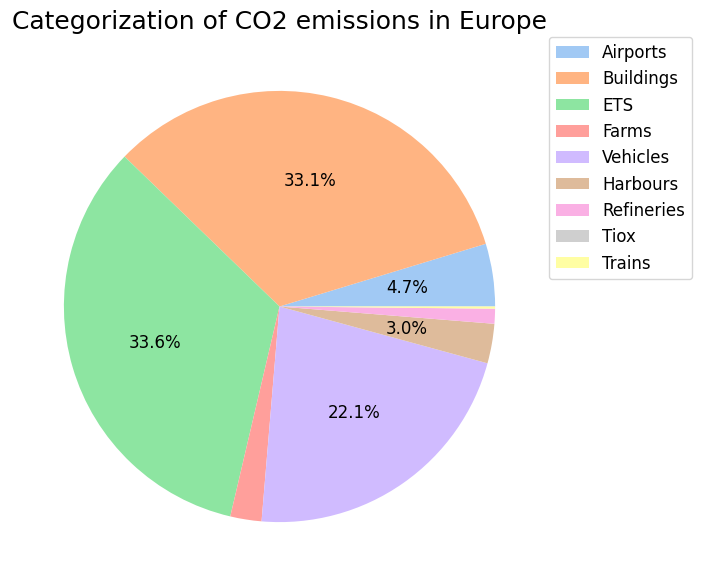

In [17]:
plt.rcParams.update(
    {
        "figure.figsize": (7, 7),
        "font.size": 12,
        "axes.titlesize": 18,
        "legend.title_fontsize": 13,
        "legend.fontsize": 12,
    }
)
ax = plt.subplot(111, aspect="equal")

colors = sns.color_palette("pastel")
patches, labels, pct_texts = ax.pie(
    df_categories.sum(),
    autopct=lambda v: f"{v:.1f}%" if v >= 2.9 else None,
    colors=colors,
    rotatelabels=True,
)
plt.legend(
    labels=df_categories.columns,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    borderaxespad=0,
)
ax.set_title("Categorization of CO2 emissions in Europe")

plt.show()

<a id='fig1'></a>
<span style="color:#990000;">**Figure 1**</span>: **Categorization of CO2 emissions in Europe**

The pie plot illustrates the distribution of total CO2 emissions across previously identified categories. Notably, the predominant contributors are buildings, industrial facilities, and vehicles. The unlabeled segments represent categories with a contribution below 3%, underscoring their relatively smaller impact on overall emissions.

---


To initiate this spatial journey, we've accessed shape data from the Eurostat website (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units), laying the groundwork for mapping and geospatial analysis. This immersive approach not only enhances our understanding of emission patterns but also sets the stage for insightful comparisons among European countries.


In [18]:
# creation of a new data frame that contains only the three categories of interest grouped by country
df_three = df.drop(
    [
        "CO2 per capita",
        "Airports",
        "Farms",
        "Harbours",
        "Refineries",
        "Tiox",
        "Trains",
    ],
    axis=1,
)
df_three_sum = df_three.groupby("Country").sum()
df_three_sum["CO2 per capita"] = (
    df_three_sum["Total (t CO2)"] / df_three_sum["Est. Population"]
)
df_three_sum.head(5)

,Est. Population,Total (t CO2),Buildings,ETS,Vehicles,CO2 per capita
Country,,,,,,
Austria,8.552469e+06,89331830,32890048,29264865,23306752,10.445151
Belgium,1.130188e+07,143122078,36475024,43130688,24925120,12.663569
Bulgaria,7.113659e+06,35285037,9356340,14685726,9110745,4.960181
Croatia,3.346881e+06,20569230,7839776,6452996,4833270,6.145790
Cyprus,5.460136e+05,2309744,293120,0,970560,4.230195


In [20]:
# eurostat data loading
df_europe = gpd.read_file("CNTR_RG_01M_2020_4326/CNTR_RG_01M_2020_4326.shp")

In [21]:
df_europe.replace({"Czechia": "Czech Rep."}, inplace=True)
df_europe.replace({"Türkiye": "Turkey"}, inplace=True)
df_europe.replace({"United Kingdom": "Great Britain"}, inplace=True)

In [22]:
# checking country name differences between the data frames
countries = df.reset_index()["Country"]
countries_geo = df_europe["NAME_ENGL"].tolist()

countries_set = set(countries)
countries_geo_set = set(countries_geo)

countries_to_drop = list(countries_geo_set.difference(countries_set))
countries_check = list(countries_set.difference(countries_geo_set))

In [23]:
# drop differences
df_europe_filtered = df_europe[~df_europe["NAME_ENGL"].isin(countries_to_drop)]
df_europe_filtered.shape

(34, 13)

In [24]:
polygon = box(-10, 30, 60, 85)
df_europe_filtered = gpd.clip(df_europe_filtered, polygon)

In [25]:
df_europe_filtered.rename(columns={"NAME_ENGL": "Country"}, inplace=True)

In [26]:
# data frame merging
df_map = df_europe_filtered.merge(df_three_sum.reset_index(), on="Country")
df_map.head(3)

,CNTR_ID,CNTR_NAME,Country,NAME_FREN,ISO3_CODE,SVRG_UN,CAPT,EU_STAT,EFTA_STAT,CC_STAT,NAME_GERM,FID,geometry,Est. Population,Total (t CO2),Buildings,ETS,Vehicles,CO2 per capita
0,FR,France,France,France,FRA,UN Member State,Paris,T,F,F,Frankreich,FR,"MULTIPOLYGON (((9.43144 43.00275, 9.44166 42.9...",6.433001e+07,392300428,140343192,86191182,122359370,6.098249
1,ES,España,Spain,Espagne,ESP,UN Member State,Madrid,T,F,F,Spanien,ES,"MULTIPOLYGON (((4.10332 40.04638, 4.10726 40.0...",4.374156e+07,293340959,66500280,101173864,83008794,6.706230
2,MT,Malta-Malta,Malta,Malte,MLT,UN Member State,Valletta,T,F,F,Malta,MT,"MULTIPOLYGON (((14.37539 35.98775, 14.36608 35...",3.730253e+05,1152509,165753,0,498186,3.089627


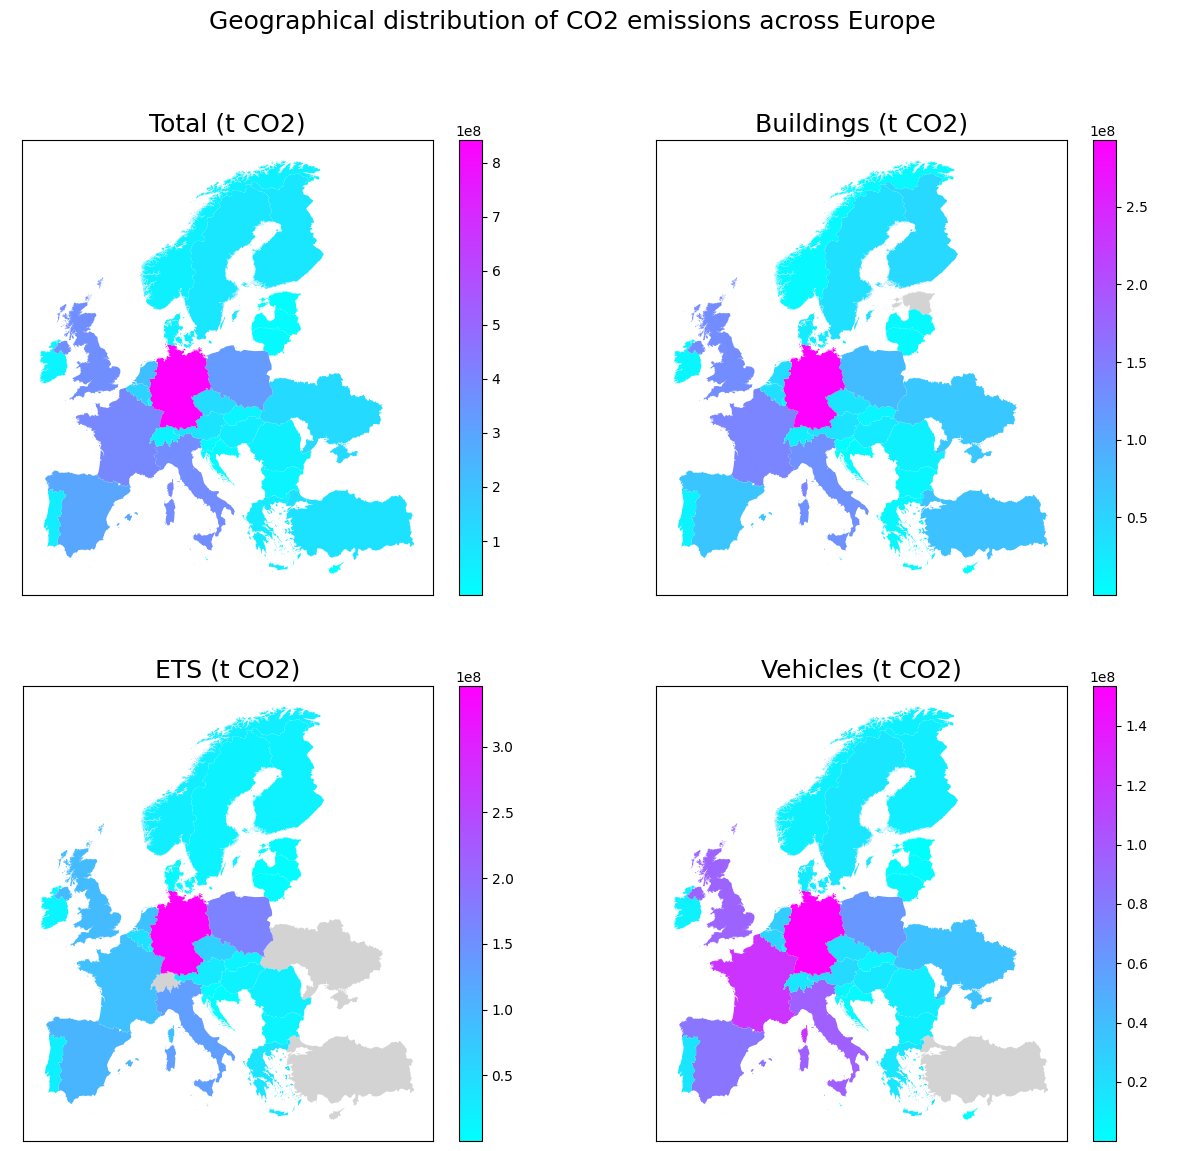

In [27]:
plt.rcParams.update(
    {
        "figure.figsize": (15, 13),
        "font.size": 10,
        "legend.title_fontsize": 12,
        "legend.fontsize": 10,
    }
)

fig, axs = plt.subplots(2, 2)
for ax in axs.ravel():
    ax.set_axis_off()

fig.suptitle(
    "Geographical distribution of CO2 emissions across Europe", fontsize=18
)

i = 1

for column in ["Total (t CO2)", "Buildings", "ETS", "Vehicles"]:
    ax = fig.add_subplot(2, 2, i)
    plt.tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False,
    )

    # Plot no-data countries in grey
    df_map_blank = df_map[df_map[column] == 0]
    if len(df_map_blank) > 0:
        df_map_blank.plot(color="lightgrey", ax=ax)

    df_map_filtered = df_map[df_map[column] != 0]
    df_map_filtered.plot(
        df_map_filtered[column], legend=True, cmap="cool", ax=ax
    )
    ax.set_title(f"{column.split()[0]} (t CO2)")
    i += 1

plt.show()

<a id='fig2a'></a>
<span style="color:#990000;">**Figure 2a**</span>: **Geographical distribution of total CO2 emissions across Europe**

Germany, France, Great Britain, and Italy stand out as the top four countries in total emissions. Notably, in the buildings category, dominance is shared by Germany, France, Italy, and Great Britain; for Emission Trading System (ETS), it's Germany, Poland, and Italy; and in the vehicles category, Germany, France, Italy, Great Britain, and Spain lead the way. Noteworthy is the consistent trend of Germany displaying highest.

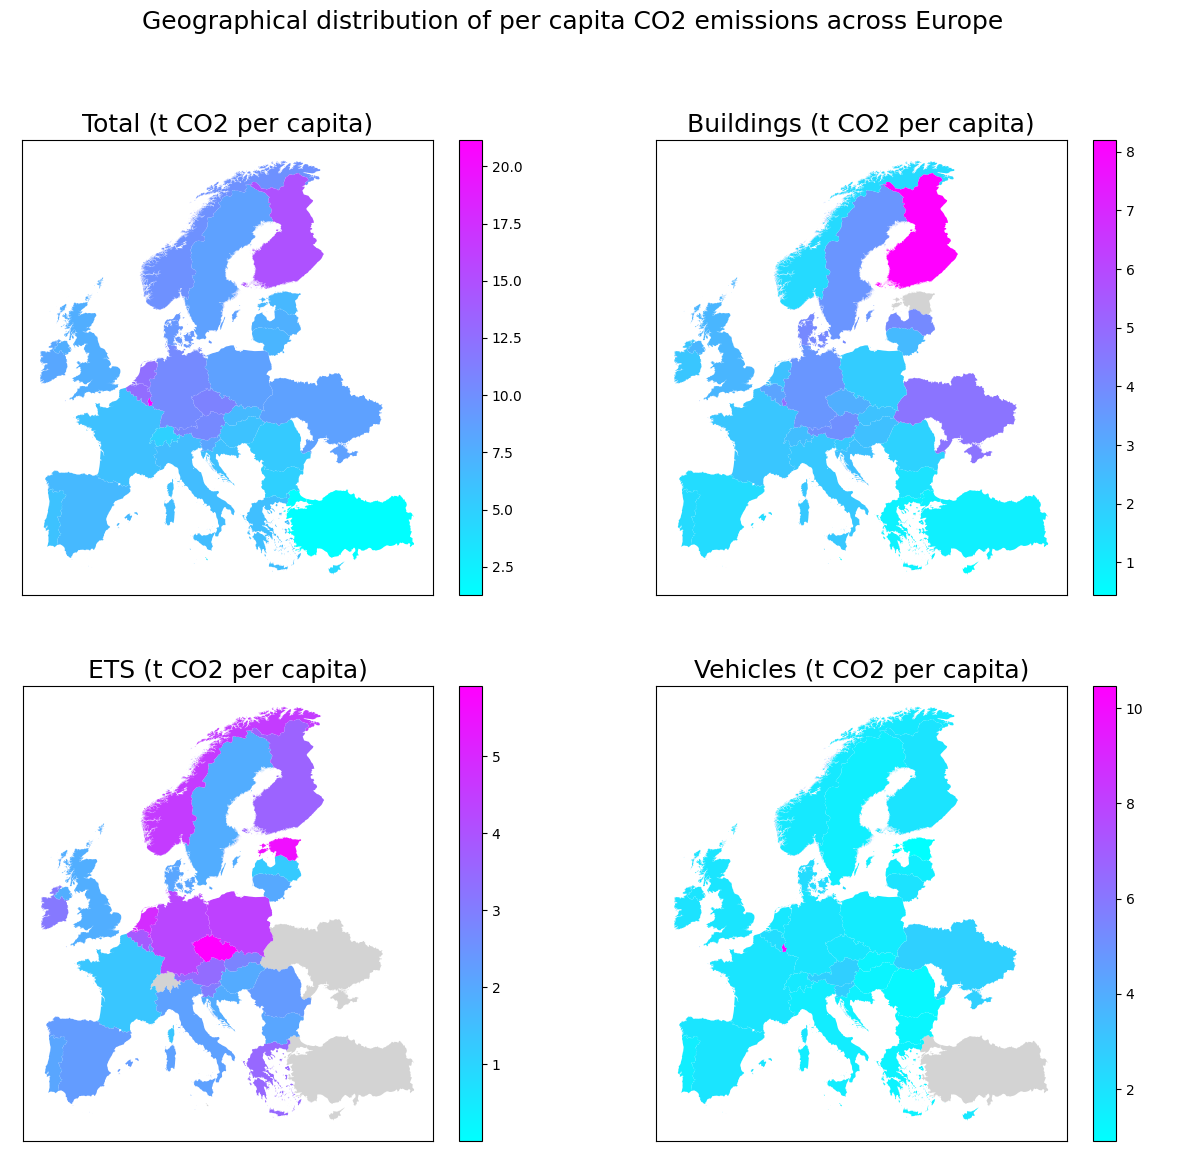

In [28]:
plt.rcParams.update(
    {
        "figure.figsize": (15, 13),
        "font.size": 10,
        "legend.title_fontsize": 12,
        "legend.fontsize": 10,
    }
)

fig, axs = plt.subplots(2, 2)
for ax in axs.ravel():
    ax.set_axis_off()

fig.suptitle(
    "Geographical distribution of per capita CO2 emissions across Europe",
    fontsize=18,
)

i = 1

for column in ["Total (t CO2)", "Buildings", "ETS", "Vehicles"]:
    ax = fig.add_subplot(2, 2, i)
    plt.tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False,
    )

    # Plot no-data countries in grey
    df_map_blank = df_map[df_map[column] == 0]
    if len(df_map_blank) > 0:
        df_map_blank.plot(color="lightgrey", ax=ax)

    df_map_filtered = df_map[df_map[column] != 0]
    df_map_filtered.plot(
        df_map_filtered[column] / df_map_filtered["Est. Population"],
        legend=True,
        cmap="cool",
        ax=ax,
    )
    ax.set_title(f"{column.split()[0]} (t CO2 per capita)")
    i += 1

plt.show()

<a id='fig2b'></a>
<span style="color:#990000;">**Figure 2b**</span>: **Geographical distribution of per capita CO2 emissions across Europe**

The scenario changes significantly when we observe the distribution of CO2 per capita. Particularly, it is evident in the map related to the ETS (Emissions Trading System) the relocation of industrial facilities to countries where labor costs are lower.

---


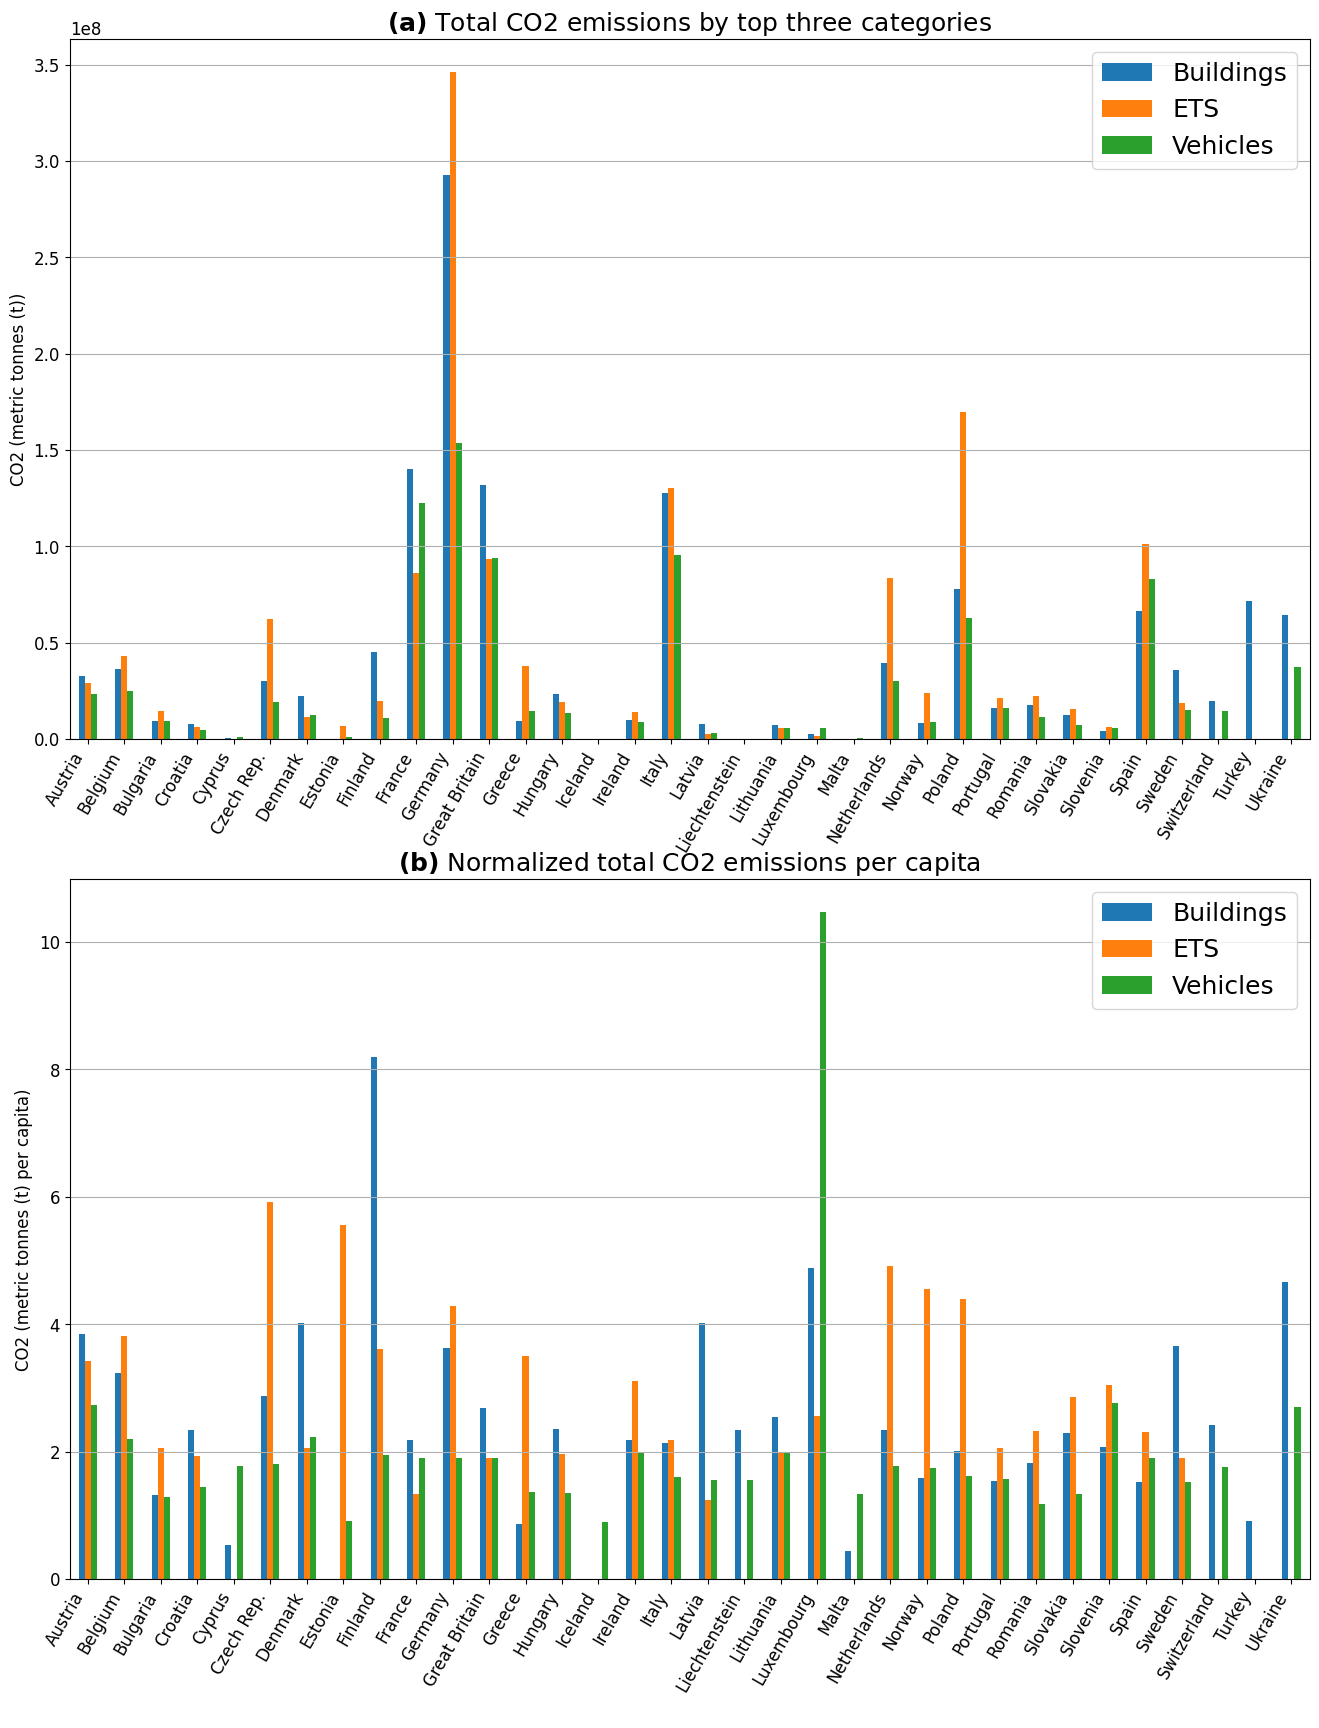

In [29]:
plt.rcParams.update(
    {
        "figure.figsize": (16, 20),
        "font.size": 12,
        "legend.title_fontsize": 15,
        "legend.fontsize": 18,
    }
)

fig, axs = plt.subplots(2, 1)
for ax in axs.ravel():
    ax.set_axis_off()

colors = sns.color_palette("Paired")

ax = fig.add_subplot(2, 1, 1)
df_three_sum.reset_index().plot(
    ax=ax,
    x="Country",
    y=["Buildings", "ETS", "Vehicles"],
    kind="bar",
    stacked=False,
)
ax.yaxis.grid()
ax.set_ylabel("CO2 (metric tonnes (t))")
ax.set_xlabel(" ")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.set_title(r"$\bf{(a)}$ Total CO2 emissions by top three categories")

# values normalization
columns_to_normalize = ["Buildings", "ETS", "Vehicles"]
df_three_norm = df_three_sum[columns_to_normalize].div(
    df_three_sum["Est. Population"], axis=0
)

ax = fig.add_subplot(2, 1, 2)
df_three_norm.reset_index().plot(
    ax=ax,
    x="Country",
    y=["Buildings", "ETS", "Vehicles"],
    kind="bar",
    stacked=False,
)
ax.yaxis.grid()
ax.set_ylabel("CO2 (metric tonnes (t) per capita)")
ax.set_xlabel(" ")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.set_title(r"$\bf{(b)}$ Normalized total CO2 emissions per capita")

plt.show()

<a id='fig3'></a>
<span style="color:#990000;">**Figure 3**</span>: **Total CO2 emissions by top three categories**

Panel (a) illustrates the total CO2 emissions (in metric tonnes) attributed to the three categories with the highest values. Notably, Germany exhibits the highest emissions, yet these values are intricately tied to the overall population numbers. The emissions in this context strongly correlate with the total population of each country. In contrast, panel (b) showcases the total CO2 emissions normalized over the population, revealing a distinct shift in the distribution per capita. This normalization provides a clearer perspective on the environmental impact, accounting for variations in population sizes. The observed changes emphasize the importance of considering per capita metrics when assessing the relative impact of emissions across different countries.

---


We observe the presence of missing data, which poses no issue during the exploratory analysis phase. However, for correlation analysis, these missing values will be excluded from consideration as they can impact the quality of the fit. (see [Sec. 4](#4)).


<a id='4'></a>

## 4. Correlation analysis and Fit


The provided data frame represents CO2 emissions categorized into various groups. Consequently, we anticipate robust correlations among these categories as they pertain to the same type of pollution. Initially, I visualized the correlation matrix, followed by linear regressions.

As anticipated earlier, a few missing data points could influence the correlation analysis. To ensure a clearer view of the correlations, I have opted to drop these missing values from the dataset.


In [30]:
df_three_sum = df_three_sum.reset_index()

In [31]:
def drop_rows_with_zeros(data, columns_to_check):
    for column in columns_to_check:
        data = data[data[column] != 0]
    return data

In [32]:
columns_to_check = ["Buildings", "ETS", "Vehicles"]
df_three_sum_no_zeros = drop_rows_with_zeros(df_three_sum, columns_to_check)

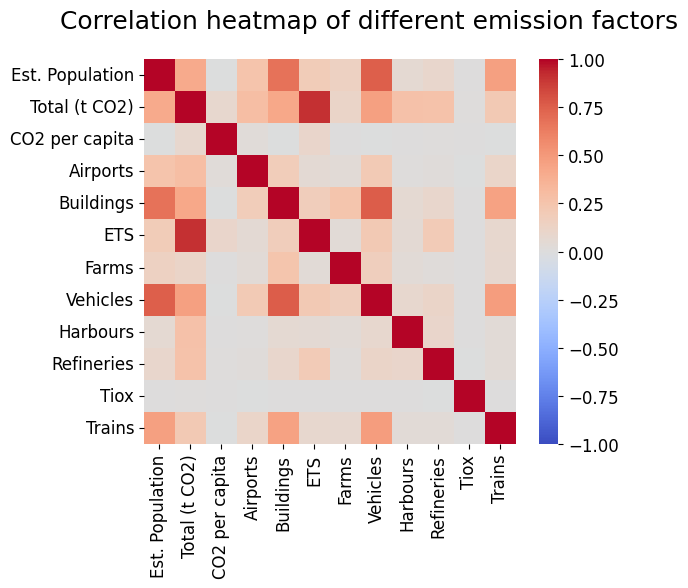

In [33]:
plt.rcParams.update({"font.size": 12, "legend.title_fontsize": 12})
fig, ax = plt.subplots(figsize=(6, 5))
fig.suptitle("Correlation heatmap of different emission factors", fontsize=18)

sns.heatmap(
    df.drop("Country", axis=1).corr(),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",  # colormap divergente
    ax=ax,
)

plt.show()

<a id='fig4'></a>
<span style="color:#990000;">**Figure 4**</span>: **Correlation heatmap of different emission factors**

This heatmap provides a detailed exploration of the correlation matrix among specific emission factors across European countries. Each square illustrates the correlation coefficient between distinct types of emissions, such as those from buildings, Emission Trading System (ETS), vehicles, and others. Warmer hues signify positive correlations, cooler hues indicate negative correlations, and a lack of color denotes a near-zero correlation.

---


**Linear Regression**

In this part, I used linear regression analysis to unravel the interrelationships among various variables in our dataset. Employing this tool, I aim to demonstrate the correlation between different factors and shed light on potential patterns and trends. This analytical approach allows us to quantify the strength and direction of connections between variables, providing a robust foundation for understanding the web of influences within our dataset.


In [34]:
# add a constant term for intercept
X1 = sm.add_constant(df_three_sum["Est. Population"])
y1 = df_three_sum["Total (t CO2)"]

X2 = sm.add_constant(df_three_sum["Buildings"])
y2 = df_three_sum["ETS"]

X3 = sm.add_constant(df_three_sum["Vehicles"])
y3 = df_three_sum["ETS"]

X4 = sm.add_constant(df_three_sum["Vehicles"])
y4 = df_three_sum["Buildings"]

# create and fit the model
model1 = sm.OLS(y1, X1).fit()
model2 = sm.OLS(y2, X2).fit()
model3 = sm.OLS(y3, X3).fit()
model4 = sm.OLS(y4, X4).fit()

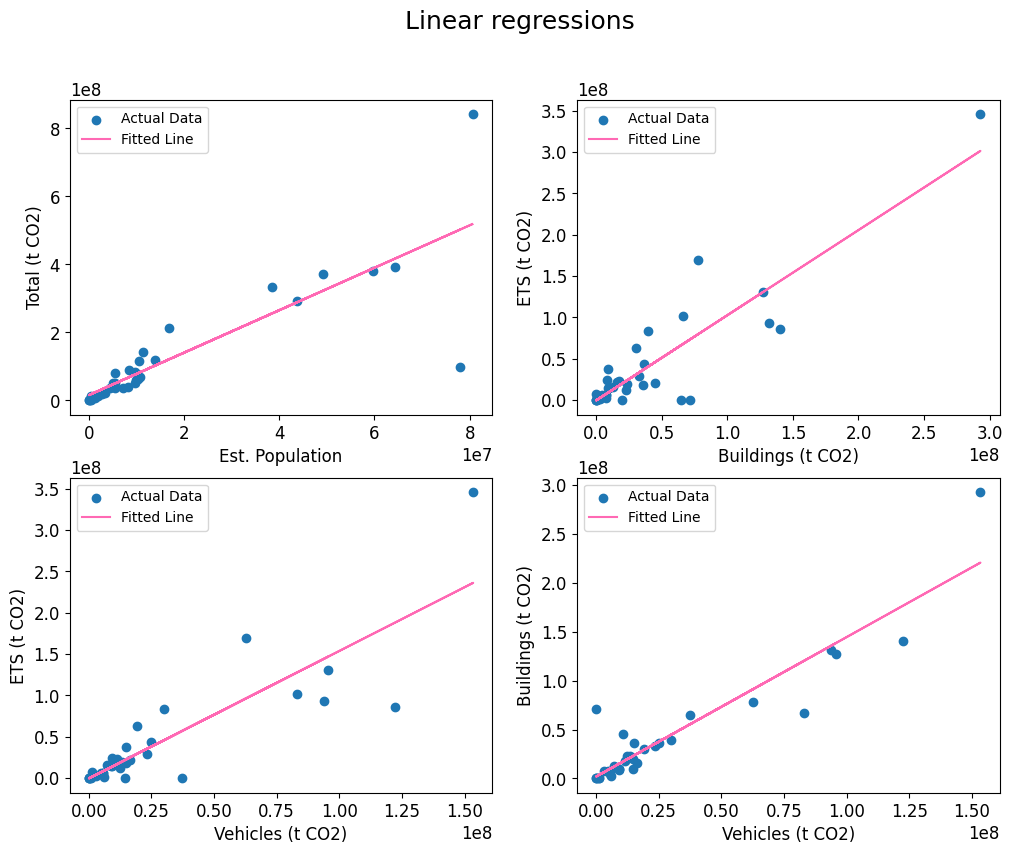

In [35]:
plt.rcParams.update(
    {
        "figure.figsize": (12, 9),
        "font.size": 12,
        "legend.title_fontsize": 12,
        "legend.fontsize": 10,
    }
)

fig, axs = plt.subplots(2, 2)
for ax in axs.ravel():
    ax.set_axis_off()

fig.suptitle("Linear regressions", fontsize=18)

y_pred1 = model1.predict(X1)
y_pred2 = model2.predict(X2)
y_pred3 = model3.predict(X3)
y_pred4 = model4.predict(X4)

# plot the data and the fitted line
ax = fig.add_subplot(2, 2, 1)
plt.scatter(
    df_three_sum["Est. Population"],
    df_three_sum["Total (t CO2)"],
    label="Actual Data",
)
plt.plot(
    df_three_sum["Est. Population"],
    y_pred1,
    color="hotpink",
    label="Fitted Line",
)
plt.xlabel("Est. Population")
plt.ylabel("Total (t CO2)")
plt.legend()

ax = fig.add_subplot(2, 2, 2)
plt.scatter(
    df_three_sum["Buildings"], df_three_sum["ETS"], label="Actual Data"
)
plt.plot(
    df_three_sum["Buildings"], y_pred2, color="hotpink", label="Fitted Line"
)
plt.xlabel("Buildings (t CO2)")
plt.ylabel("ETS (t CO2)")
plt.legend()

ax = fig.add_subplot(2, 2, 3)
plt.scatter(df_three_sum["Vehicles"], df_three_sum["ETS"], label="Actual Data")
plt.plot(
    df_three_sum["Vehicles"], y_pred3, color="hotpink", label="Fitted Line"
)
plt.xlabel("Vehicles (t CO2)")
plt.ylabel("ETS (t CO2)")
plt.legend()

ax = fig.add_subplot(2, 2, 4)
plt.scatter(
    df_three_sum["Vehicles"], df_three_sum["Buildings"], label="Actual Data"
)
plt.plot(
    df_three_sum["Vehicles"], y_pred4, color="hotpink", label="Fitted Line"
)
plt.xlabel("Vehicles (t CO2)")
plt.ylabel("Buildings (t CO2)")
plt.legend()

plt.show()

<a id='fig5'></a>
<span style="color:#990000;">**Figure 5**</span>: **Linear regressions for environmental impact factors**

This figure presents linear regressions for key environmental impact factors across European countries. Each subplot showcases the relationship between two variables: Est. Population vs. Total CO2 emissions, Buildings vs. ETS (Emission Trading System), Vehicles vs. ETS, and Vehicles vs. Buildings. The scatter plots depict the actual data points, while the hot pink lines represent the fitted linear regression models. These visualizations provide insights into the potential associations and trends between population estimates, CO2 emissions, and specific environmental sectors.

---


In this final part of the section, I adopted a different approach to gain deeper insights into the dataset by fitting the population distribution through the lens of a logarithmic scale. This strategic choice is driven by the desire to extract more information regarding population dynamics and, by extension, their implications for CO2 emissions. To do that I used

- Normal distribution $N(x|λ,σ) = \frac{1}{\sqrt{2π} σ}\ e^{\frac{-(x - μ)} {2 {σ}^2}}$

- Gamma distribution $G(x|ν,λ) = \frac{λ ν}{Γ(ν)}\ x^{ν-1}\ e^{-λx}$


In [36]:
df_no_zeros = drop_rows_with_zeros(df, ["Est. Population"])
df_no_zeros["log_Val"] = np.log(df_no_zeros["Est. Population"])

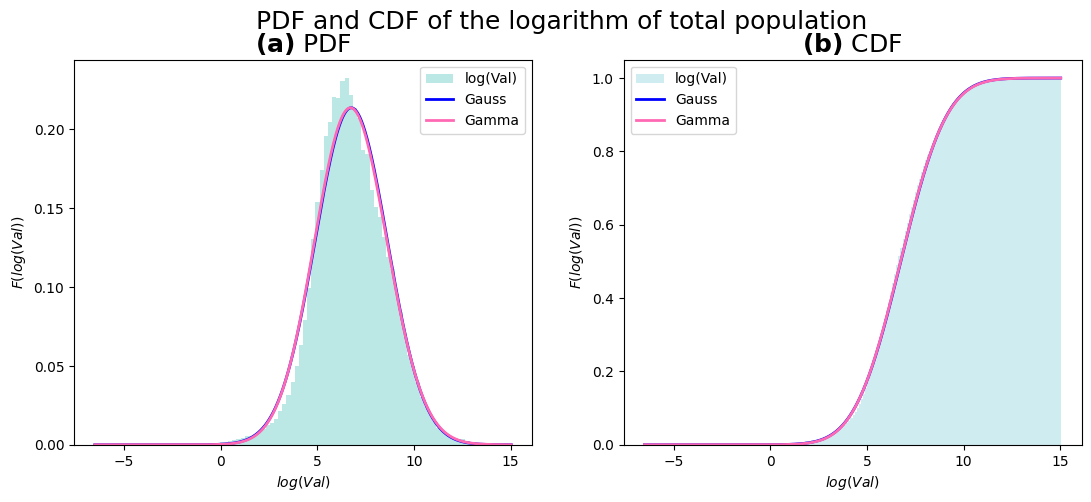

In [37]:
plt.rcParams.update(
    {
        "figure.figsize": (13, 5),
        "font.size": 10,
        "legend.title_fontsize": 12,
        "legend.fontsize": 10,
    }
)

fig, axs = plt.subplots(1, 2)
for ax in axs.ravel():
    ax.set_axis_off()

fig.suptitle("PDF and CDF of the logarithm of total population", fontsize=18)

m = df_no_zeros.log_Val.min()
M = df_no_zeros.log_Val.max()
x = np.linspace(m, M, 1000)

ax1 = fig.add_subplot(1, 2, 1)

# PDF
plt.hist(
    df_no_zeros.log_Val,
    bins=100,
    density=True,
    label="log(Val)",
    alpha=0.3,
    color="lightseagreen",
)

# Gauss
a, b = stats.norm.fit(df_no_zeros.log_Val)
Gauss = stats.norm(a, b)
ax1.plot(x, Gauss.pdf(x), color="blue", lw=2, label="Gauss")

# Gamma (includes Chi2 e Exp)
a, b, c = stats.gamma.fit(df_no_zeros.log_Val)
Gamma = stats.gamma(a, b, c)
ax1.plot(x, Gamma.pdf(x), color="hotpink", lw=2, label="Gamma")

plt.legend()

ax2 = fig.add_subplot(1, 2, 2)

# CDF
ax2.hist(
    df_no_zeros.log_Val,
    bins=200,
    density=True,
    cumulative=True,
    alpha=0.6,
    color="powderblue",
    label="log(Val)",
)

# Gauss
ax2.plot(x, Gauss.cdf(x), color="blue", lw=2, label="Gauss")

# Gamma (includes Chi2 e Exp)
ax2.plot(x, Gamma.cdf(x), color="hotpink", lw=2, label="Gamma")

plt.legend()

ax1.set_xlabel(r"$log(Val)$")
ax1.set_ylabel(r"$F(log(Val))$")
ax1.set_title(r"$\bf{(a)}$ PDF")

ax2.set_xlabel(r"$log(Val)$")
ax2.set_ylabel(r"$F(log(Val))$")
ax2.set_title(r"$\bf{(b)}$ CDF")

plt.show()

<a id='fig6'></a>
<span style="color:#990000;">**Figure 6**</span>: **PDF and CDF of the logarithm of total population**

Figure (a) illustrates the Probability Density Function (PDF) of the logarithm of the total population across European countries. The logarithmic transformation provides a clearer representation of the distribution, emphasizing relative differences and facilitating the analysis of population patterns on a logarithmic scale. Figure (b) representss the Cumulative Distribution Function (CDF) of the logarithm of the total population in Europe is presented. The CDF visually captures the cumulative probability of observing a population less than or equal to a given value.

---


<a id='5'></a>

## 5. Statistic tests and conclusions


**Linear Regression tests**


In a linear regression context we can check the goodness of our results using different paramenters and tests:

- $\bf{R²}$ that measures the proportion of the variance in the dependent variable that is explained by the independent variable(s) in the model
- $\bf{F-statistic}$ that tests the overall significance of the linear regression model

An R² value close to 1 indicates a good fit, meaning that a large proportion of the variability in the dependent variable is accounted for by the independent variable(s).  
The F-statistic tests the null hypothesis that all the coefficients in the model, except the intercept, are equal to zero. If the F-statistic is significant, it suggests that at least one of the predictors in the model has a non-zero effect on the response variable. A high F-statistic suggests that the model as a whole is statistically significant.

In summary, R² measures the goodness of fit, the F-statistic tests the overall significance of the model, and the p-value for the F-statistic helps determine whether the model is statistically significant.


In [38]:
# print summary statistics
print(f"(Est. Population - Total (t CO2)) R² Value: {model1.rsquared}")
print(f"(Buildings - ETS) R² Value: {model2.rsquared}")
print(f"(Vehicles - ETS) R² Value: {model3.rsquared}")
print(f"(Vehicles - Buildings) R² Value: {model4.rsquared}")
print("")
print(f"(Est. Population - Total (t CO2)) F Statistic: {model1.fvalue}")
print(f"(Buildings - ETS) F Statistic: {model2.fvalue}")
print(f"(Vehicles - ETS) F Statistic: {model3.fvalue}")
print(f"(Vehicles - Buildings) F Statistic: {model4.fvalue}")
print("")
print(f"(Est. Population - Total (t CO2)) Log-Likelihood: {model1.llf}")
print(f"(Buildings - ETS) Log-Likelihood: {model2.llf}")
print(f"(Vehicles - ETS) Log-Likelihood: {model3.llf}")
print(f"(Vehicles - Buildings) Log-Likelihood: {model4.llf}")

(Est. Population - Total (t CO2)) R² Value: 0.7010542502095063
(Buildings - ETS) R² Value: 0.792996213136263
(Vehicles - ETS) R² Value: 0.7497975636478431
(Vehicles - Buildings) R² Value: 0.858958421826038

(Est. Population - Total (t CO2)) F Statistic: 75.04283309739694
(Buildings - ETS) F Statistic: 122.58654397015657
(Vehicles - ETS) F Statistic: 95.8964364478066
(Vehicles - Buildings) F Statistic: 194.88345106668413

(Est. Population - Total (t CO2)) Log-Likelihood: -672.1721288066545
(Buildings - ETS) Log-Likelihood: -634.2429395246098
(Vehicles - ETS) Log-Likelihood: -637.4650047487389
(Vehicles - Buildings) Log-Likelihood: -622.7444022445258


We see that for each linear regressions the log-likelihood value is very small, this implies a strong correlation among the variables.
Note that a very small log-likelihood value does not necessarily indicate that the model is correct. In fact, the log-likelihood value alone does not provide a direct assessment of model correctness; rather, it serves as a measure of how well the model fits the observed data.
As mentioned earlier, this outcome is expected since all the variables pertain to CO2 emissions, and it is reasonable to assume that they share a similar distribution. Specifically, we can assert that they all align with the distribution of the population.

**Kolmogorov-Smirnov test**

The Kolmogorov-Smirnov test is a non-parametric test used to assess whether a sample comes from a specific distribution. It measures the maximum absolute difference between the empirical cumulative distribution function of the sample and the cumulative distribution function (CDF) of the specified distribution.  
In this case a small p-value suggests that the observed distribution significantly deviates from the specified distribution.

First of all I fix the significance level $\bf{α=0.01}$, then I go on with the first tests.

In [39]:
print("Gauss: ", stats.kstest(df_no_zeros.log_Val, lambda x: Gauss.cdf(x)))
print("Gamma: ", stats.kstest(df_no_zeros.log_Val, lambda x: Gamma.cdf(x)))

Gauss:  KstestResult(statistic=np.float64(0.023995623947572417), pvalue=np.float64(1.1898152681727737e-52), statistic_location=np.float64(4.70857273332601), statistic_sign=np.int8(-1))
Gamma:  KstestResult(statistic=np.float64(0.023830108944045206), pvalue=np.float64(6.2160117812258965e-52), statistic_location=np.float64(4.70857273332601), statistic_sign=np.int8(-1))


With KS test we have

- $p-value<\alpha$

in both cases, so we can reject the hypothesis made about the distributions.


<a id='6'></a>

## 6. Conclusions


The bell-shaped population distribution suggests that the majority of cities exhibit an average order of size, while the remaining cities follow a normal distribution across other size categories. However, the statistical test indicates that the data does not adhere to either the Normal or the Gamma distribution.

A philosophical interpretation might be as follows.
The inclination to categorize groups logarithmically may not be an inherent biological trait of human beings. Instead, it likely arises from influences rooted in cultural, cognitive, or practical considerations. Human behavior and decision-making, intricate processes, are shaped by a complex interplay of cultural, social, psychological, and environmental factors.

Notably, logarithmic scales or patterns find practical application in various fields, such as the perception of Magnitude. In psychology, there is evidence supporting the notion that humans tend to perceive differences in magnitude on a logarithmic scale. Our inherent sense of numbers appears to be logarithmic rather than linear.
